In [ ]:
!pip3 install -r requirements.txt

In [42]:
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [36]:
#load data 
path = "/Users/felix/Desktop/ML/flaschenpost/fruits-360"


#go trough folders and remove all the ones that are not banana or apple
for dirpath, dirnames, filenames in os.walk(path):
    print(dirpath)
    # get rid of not needed classes
    if "Banana" not in dirpath and "Apple" not in dirpath:
        if "Training/" in dirpath or "Test/" in dirpath:
            !rm -r {dirpath}


/Users/felix/Desktop/ML/flaschenpost/fruits-360
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Apple Red Delicious
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Banana Lady Finger
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Apple Golden 2
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Apple Red 1
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Apple Golden 3
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Apple Red Yellow 1
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Banana Red
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Apple Braeburn
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Apple Crimson Snow
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Apple Granny Smith
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Apple Pink Lady
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Apple Golden 1
/Users/felix/Desktop/ML/flaschenpost/fruits-360/Test/Banana
/Users/f

In [37]:
# Define a transform to normalize the data and appy some data augmentation
train_transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.RandomRotation(30),
                                #transforms.RandomResizedCrop(224),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])


test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,)),
                                        ])



# load the data 
trainset = datasets.ImageFolder(path + "/Training", transform=train_transform)
testset = datasets.ImageFolder(path + "/Test", transform=test_transform)


In [38]:
#merge subclasses of apple and banana to one class
for it, cl in enumerate(trainset.class_to_idx):
    if 'Apple' in cl:
        trainset.class_to_idx[cl] = 0
        indices = np.where(np.array(trainset.targets) == it)
        for ind in indices[0]:
            trainset.targets[ind] = 0
    elif 'Banana' in cl:
        trainset.class_to_idx[cl] = 1
        indices = np.where(np.array(trainset.targets) == it)
        for ind in indices[0]:
            trainset.targets[ind] = 1

for it, cl in enumerate(testset.class_to_idx):
    if 'Apple' in cl:
        testset.class_to_idx[cl] = 0
        indices = np.where(np.array(testset.targets) == it)
        for ind in indices[0]:
            trainset.targets[ind] = 0
    elif 'Banana' in cl:
        testset.class_to_idx[cl] = 1
        indices = np.where(np.array(testset.targets) == it)
        for ind in indices[0]:
            trainset.targets[ind] = 1

print(trainset.class_to_idx)

{'Apple Braeburn': 0, 'Apple Crimson Snow': 0, 'Apple Golden 1': 0, 'Apple Golden 2': 0, 'Apple Golden 3': 0, 'Apple Granny Smith': 0, 'Apple Pink Lady': 0, 'Apple Red 1': 0, 'Apple Red 2': 0, 'Apple Red 3': 0, 'Apple Red Delicious': 0, 'Apple Red Yellow 1': 0, 'Apple Red Yellow 2': 0, 'Banana': 1, 'Banana Lady Finger': 1, 'Banana Red': 1}


In [39]:
#check if there's an imbalance
n_apple = sum(np.array(trainset.targets) == 0)
n_banana = sum(np.array(trainset.targets) == 1)

print("Number of apples: ", n_apple)
print("Number of bananas: ", n_banana)

#random upsample the smaller class (banana)
indices_banana = np.where(np.array(trainset.targets) == 1)[0]
indices_banana = np.random.choice(indices_banana, n_apple)
indices_apple = np.where(np.array(trainset.targets) == 0)[0]
indices = np.concatenate((indices_banana, indices_apple))
trainset.targets = np.array(trainset.targets)[indices]
trainset.samples = np.array(trainset.samples)[indices]
trainset.imgs = np.array(trainset.imgs)[indices]

print('After rebalancing:')
print("Number of apples: ", sum(np.array(trainset.targets) == 0))
print("Number of bananas: ", sum(np.array(trainset.targets) == 1))


Number of apples:  5920
Number of bananas:  1914
After rebalancing:
Number of apples:  5920
Number of bananas:  5920


In [40]:
# Create the dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 100, 3)

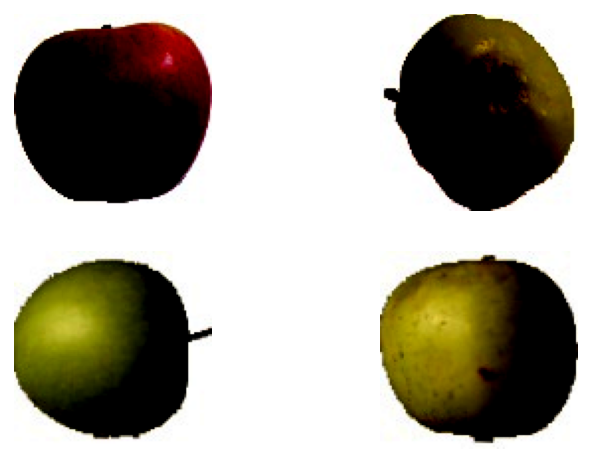

In [41]:
#let's have a look at some images
data_iter = iter(trainloader)
images, labels = next(data_iter)
for i in range(4):
    plt.subplot(2,2,i+1)
    im = np.array(images[i]).transpose(1,2,0)
    plt.imshow(im, cmap='Greys_r')
    plt.axis('off')

im.shape

In [43]:
#load pre trained model from torchvision and adjust the last layer 
def load_create_model():
    #load pre trained model from torchvision 
    resnet = models.resnet18(pretrained=True)
    #adjust the last layer to fit our problem
    resnet.fc = nn.Linear(resnet.fc.in_features, 2)
    #freeze all layers except the last one
    for param in resnet.parameters():
        param.requires_grad = False
    resnet.fc.weight.requires_grad = True
    resnet.fc.bias.requires_grad = True
    nn.init.xavier_uniform_(resnet.fc.weight)
    resnet.load_state_dict(torch.load('model.pth'))
    return resnet

model = load_create_model()

print(model)

/opt/homebrew/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Define the loss
criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Train the network
epochs = 1
steps = 0
running_loss = 0
print_every = 1
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        temp_label = torch.Tensor()
        for l in labels:
            if int(l)<13:
                c = torch.Tensor([0])
                temp_label = torch.cat((temp_label, c))
            else:
                c = torch.Tensor([1])
                temp_label = torch.cat((temp_label, c))
        labels = temp_label.type(torch.LongTensor)
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    temp_label = torch.Tensor()
                    for l in labels:
                        if int(l)<13:
                            c = torch.Tensor([0])
                            temp_label = torch.cat((temp_label, c))
                        else:
                            c = torch.Tensor([1])
                            temp_label = torch.cat((temp_label, c))
                    labels = temp_label.type(torch.LongTensor)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

        #save the model
        torch.save(model.state_dict(), 'model.pth')

cpu
Epoch 1/1.. Train loss: 2.081.. Test loss: 4.430.. Test accuracy: 0.217
Epoch 1/1.. Train loss: 2.031.. Test loss: 3.346.. Test accuracy: 0.209
Epoch 1/1.. Train loss: 1.518.. Test loss: 2.502.. Test accuracy: 0.200
Epoch 1/1.. Train loss: 1.083.. Test loss: 1.813.. Test accuracy: 0.217
Epoch 1/1.. Train loss: 1.010.. Test loss: 1.309.. Test accuracy: 0.352
Epoch 1/1.. Train loss: 0.740.. Test loss: 1.011.. Test accuracy: 0.534
Epoch 1/1.. Train loss: 0.885.. Test loss: 0.847.. Test accuracy: 0.640
Epoch 1/1.. Train loss: 0.779.. Test loss: 0.742.. Test accuracy: 0.699
Epoch 1/1.. Train loss: 0.672.. Test loss: 0.672.. Test accuracy: 0.737
Epoch 1/1.. Train loss: 0.729.. Test loss: 0.628.. Test accuracy: 0.759
Epoch 1/1.. Train loss: 0.935.. Test loss: 0.587.. Test accuracy: 0.771
Epoch 1/1.. Train loss: 0.823.. Test loss: 0.544.. Test accuracy: 0.780
Epoch 1/1.. Train loss: 0.581.. Test loss: 0.501.. Test accuracy: 0.785
Epoch 1/1.. Train loss: 0.575.. Test loss: 0.465.. Test accu

In [44]:
#load model
model.load_state_dict(torch.load('model.pth'))
#model = torch.load('model.pth')



<All keys matched successfully>

In [102]:
preds = []
model.eval()
with torch.no_grad():
    for X,_ in testloader:
        X = X.to(device)
        preds.extend(model(X).argmax(dim=1))


torch.Size([64, 3, 100, 100])


In [100]:
from sklearn.metrics import confusion_matrix



preds = np.array(preds)
#evaluate model on test set 

print(sum(preds==1))
print(sum(preds==0))

labels = []
for inputs, la in testloader:
    for l in la:
        if l<13:
            labels = np.append(labels,0)
        else:
            labels = np.append(labels,1)

print(sum(labels==1))
print(sum(labels==0))



#confusion matrix
cm = confusion_matrix(labels, preds)
print(cm)




493
2125
484
2134
[[1731  403]
 [ 394   90]]


In [51]:
#test model on jpg pictures
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
        transforms.Resize(100),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        ])

path = '/Users/felix/Desktop/fruits-360/Test/Apple Golden 1/79_100.jpg'
image = Image.open(path)

#do inference with the uploaded image 
with torch.no_grad():
    #in case of an alpha channel remove it 
    image = transform(image)[:3]
    image = torch.unsqueeze(image, 0)
    image = image.to(device)        
    model.eval()
    out = model(image).argmax(dim=1)
    if out[0]==0:
        print("an apple!")
    else:
        print("a banana!")

an apple!
